In [80]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn_evaluation import plot
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_validate

In [5]:
train_data_path = "train_dummy.csv"
test_data_path = "test_dummy.csv"

In [68]:
train_data = pd.read_csv(train_data_path, low_memory=False)
test_data = pd.read_csv(test_data_path, low_memory=False)

In [8]:
train_data.dtypes

MSSubClass                 int64
LotFrontage              float64
LotArea                    int64
OverallCond                int64
YearBuilt                  int64
                          ...   
SaleCondition_AdjLand      int64
SaleCondition_Alloca       int64
SaleCondition_Family       int64
SaleCondition_Normal       int64
SaleCondition_Partial      int64
Length: 256, dtype: object

In [69]:
#Scaling
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_train_data = pd.DataFrame(scaled_train, columns=train_data.columns)
scaled_test = scaler.transform(test_data)
scaled_test_data = pd.DataFrame(scaled_test,columns=test_data.columns)

In [10]:
scaled_train_data.shape

(940, 256)

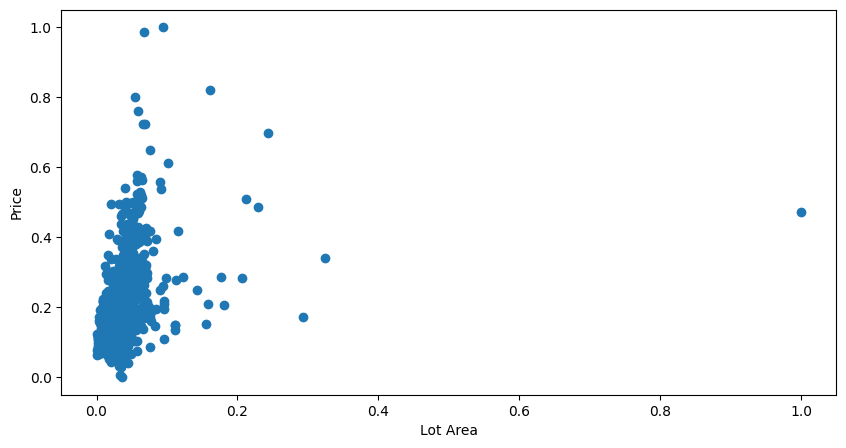

In [287]:
plt.figure(figsize=(10,5))
plt.scatter(x=scaled_train_data["LotArea"], y=scaled_train_data['SalePrice'], )
plt.xlabel('Lot Area')
plt.ylabel('Price')
plt.show()

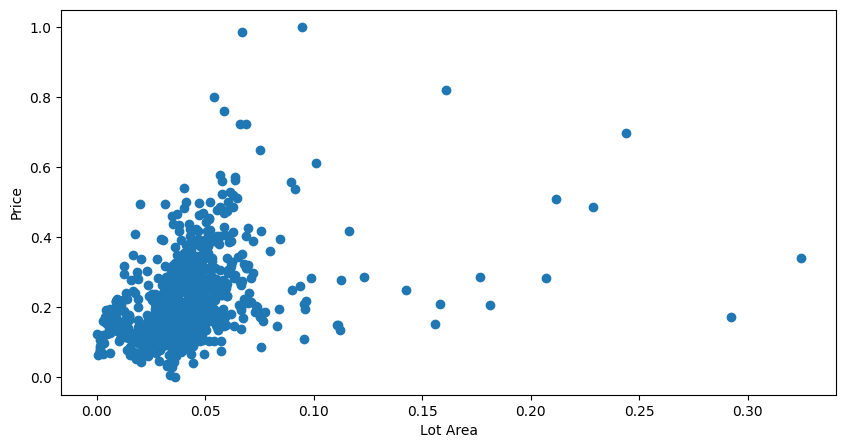

In [289]:
plt.figure(figsize=(10,5))
plt.scatter(x=scaled_train_data["LotArea"], y=scaled_train_data['SalePrice'], )
plt.xlabel('Lot Area')
plt.ylabel('Price')
plt.show()

In [70]:
#Vypisanie najviac korelujucich hodnot
corr = train_data.corr().abs()
highest_corr = corr.unstack()
sorted_highest_corr = highest_corr.sort_values(ascending=False).drop_duplicates()

In [291]:
fig = px.imshow(corr)
fig.write_html("corr_matrix.html")

<AxesSubplot: >

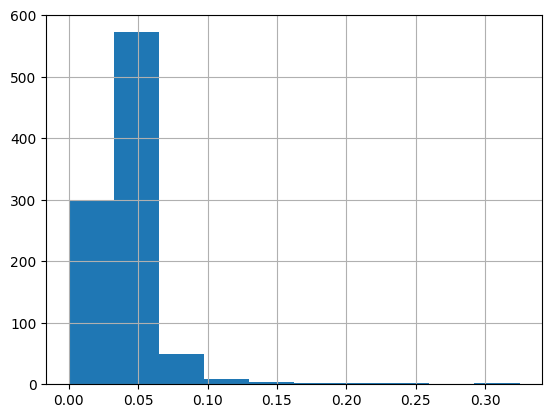

In [14]:
scaled_train_data["LotArea"].hist()

In [71]:
X_train = scaled_train_data.drop('SalePrice', axis=1)
y_train = scaled_train_data['SalePrice']
X_columns = scaled_train_data.drop('SalePrice', axis=1).columns
X_test = scaled_test_data.drop('SalePrice', axis=1)
y_test = scaled_test_data['SalePrice']

In [16]:
print(np.shape(X_train))
print(np.shape(y_train))

(939, 255)
(939,)


In [295]:
param_grid = {'max_features': ['sqrt', 'log2',1.0],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['squared_error', 'absolute_error'],
              'min_samples_leaf': [1,2,3,4]
             }

In [296]:
regressor = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=regressor,
                           param_grid=param_grid,
                           scoring=["r2","neg_mean_squared_error"],
                           refit="r2",
                           cv=5, verbose=4)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV 1/5] END ccp_alpha=0.1, criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1; neg_mean_squared_error: (test=-0.014) r2: (test=-0.001) total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1; neg_mean_squared_error: (test=-0.010) r2: (test=-0.004) total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1; neg_mean_squared_error: (test=-0.017) r2: (test=-0.000) total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1; neg_mean_squared_error: (test=-0.015) r2: (test=-0.001) total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1; neg_mean_squared_error: (test=-0.012) r2: (test=-0.001) total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterio

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [5, 6, 7, 8, 9],
                         'max_features': ['sqrt', 'log2', 1.0],
                         'min_samples_leaf': [1, 2, 3, 4]},
             refit='r2', scoring=['r2', 'neg_mean_squared_error'], verbose=4)

In [297]:
print("BEST ESTIMATOR: " + str(grid_search.best_estimator_))
print("BEST SCORE: " + str(grid_search.best_score_))

BEST ESTIMATOR: DecisionTreeRegressor(ccp_alpha=0.001, criterion='absolute_error', max_depth=5,
                      max_features=1.0)
BEST SCORE: 0.6556738481677334


In [298]:
tree_results = pd.DataFrame(grid_search.cv_results_)
tree_results = tree_results.sort_values("rank_test_r2")
tree_results.to_csv("tree_results.csv")

In [299]:
best_tree_regressor = DecisionTreeRegressor(ccp_alpha=0.001, criterion='absolute_error', max_depth=5,min_samples_leaf=2)
best_tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.001, criterion='absolute_error', max_depth=5,
                      min_samples_leaf=2)

<AxesSubplot: title={'center': 'Residuals Plot'}, xlabel='Predicted Value', ylabel='Residuals'>

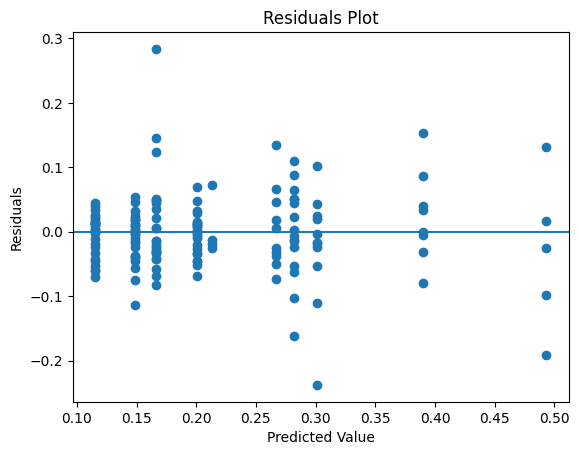

In [300]:
y_pred = best_tree_regressor.predict(X_test)
y_true = y_test
plot.residuals(y_true, y_pred)

In [301]:
tree_test_results = cross_validate(best_tree_regressor,X_test,y_test,scoring=["r2","neg_mean_squared_error"])
tree_test_results

{'fit_time': array([0.01400304, 0.01300001, 0.01500392, 0.0130024 , 0.01300263]),
 'score_time': array([0.00200105, 0.00400114, 0.00200057, 0.00200057, 0.00300097]),
 'test_r2': array([-0.25828681,  0.39156956,  0.6567265 ,  0.68839996,  0.49400117]),
 'test_neg_mean_squared_error': array([-0.0081161 , -0.00827073, -0.00312219, -0.0043165 , -0.00692855])}

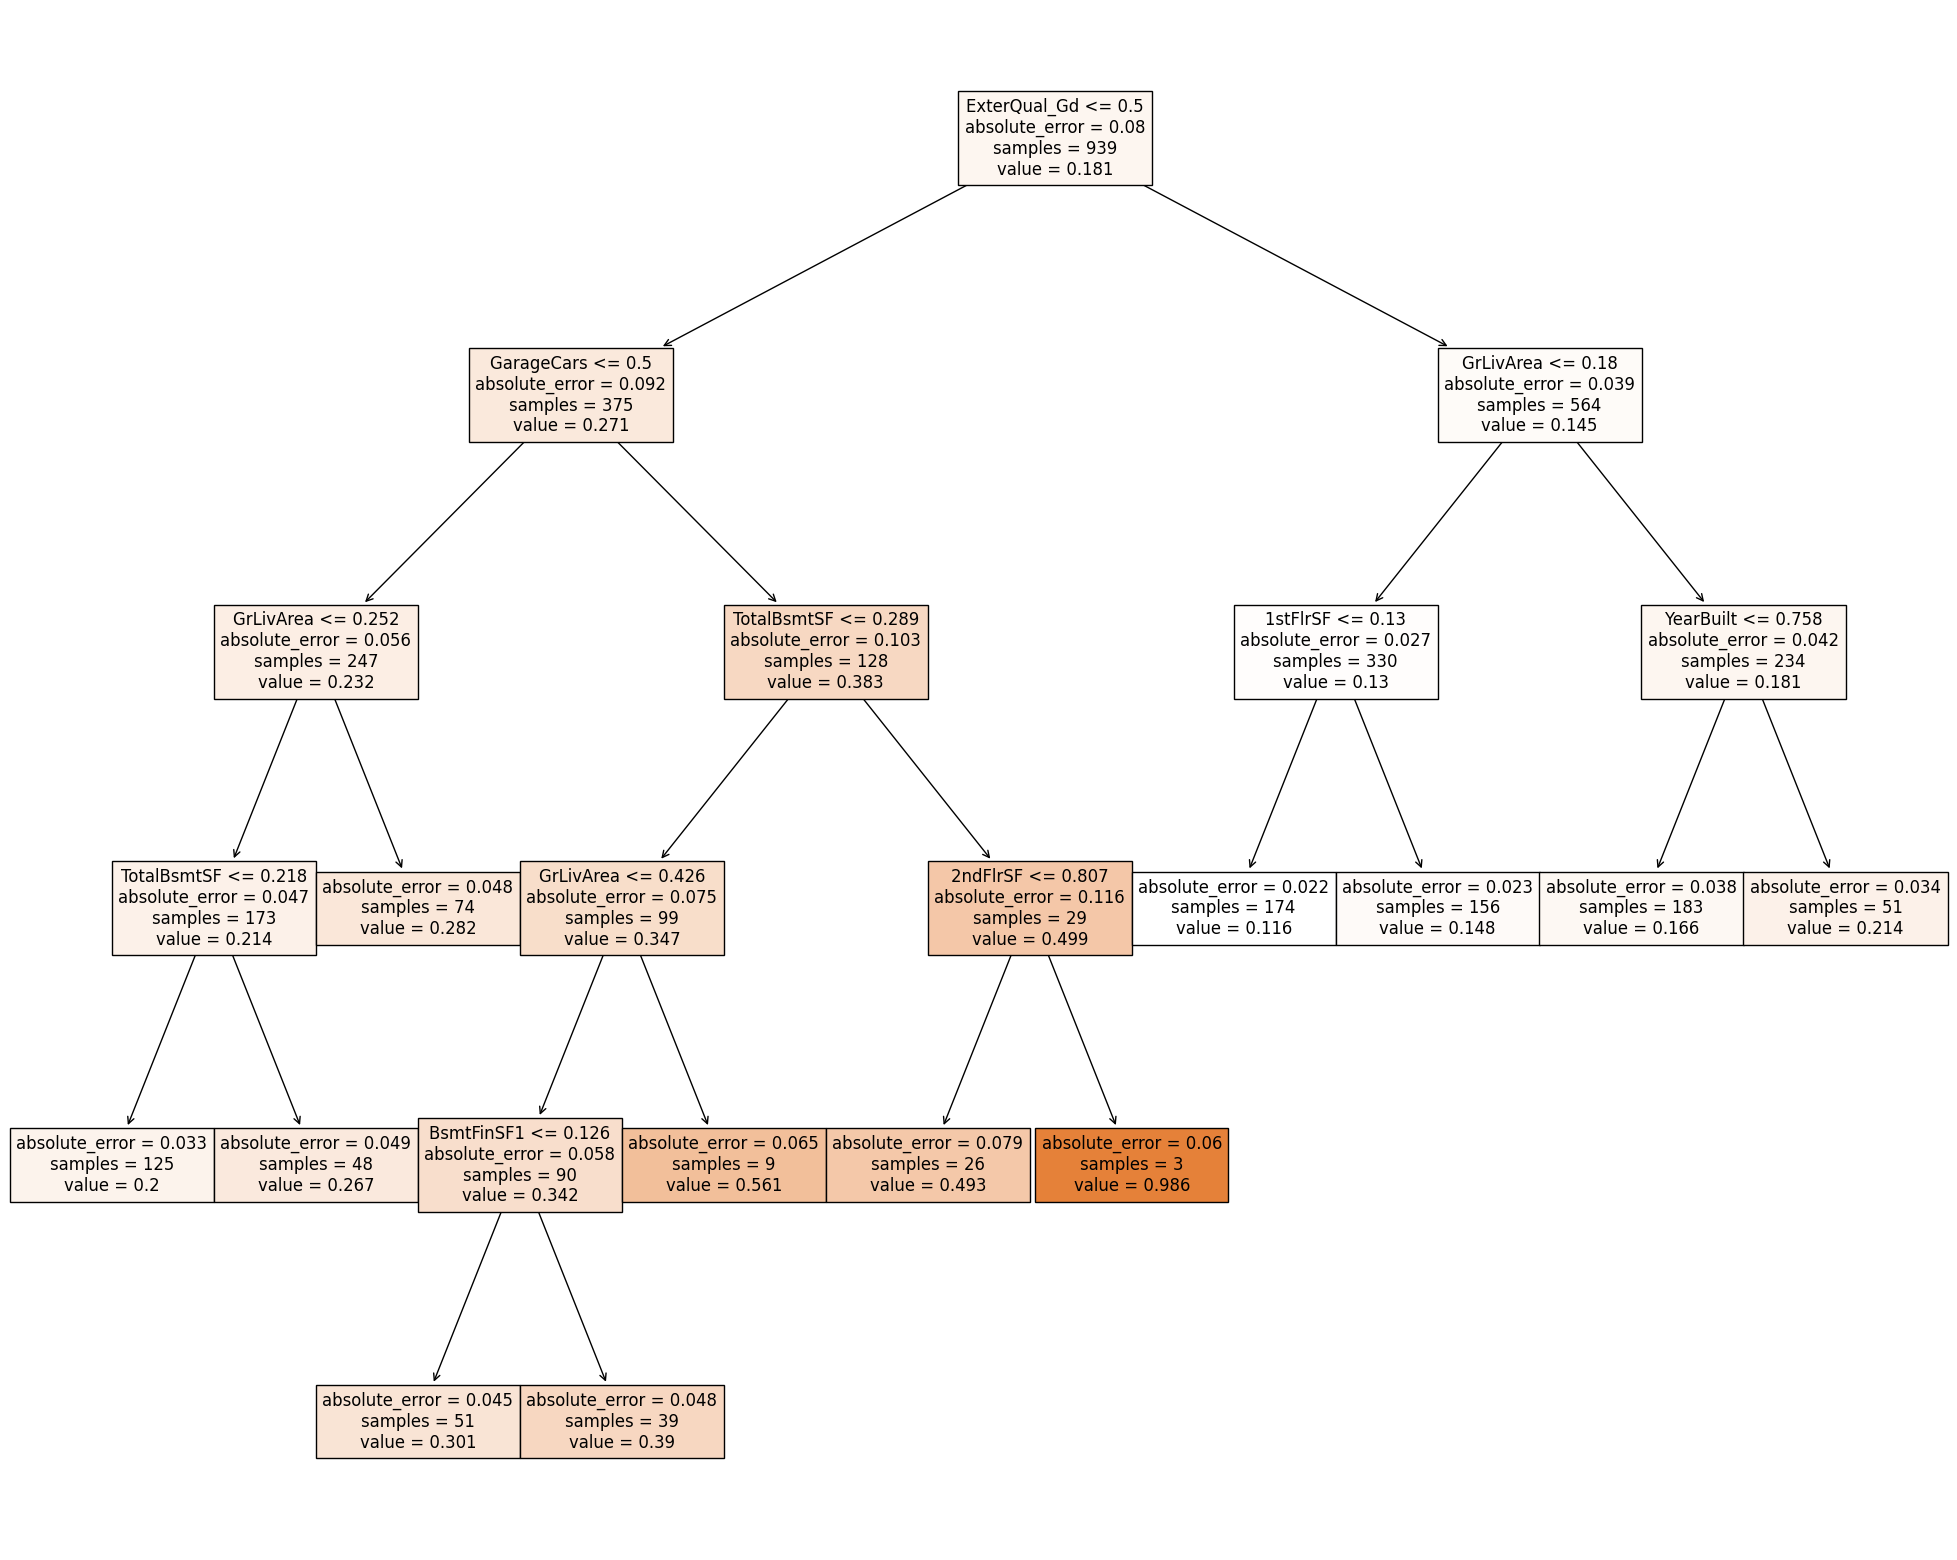

In [302]:
text_representation = tree.export_text(best_tree_regressor)
feature_names = list(scaled_train_data.columns.values)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_tree_regressor,feature_names= feature_names,
                   filled=True)
fig.savefig('decisionTree.png')

In [303]:
param = {'kernel' : ('linear', 'poly', 'rbf'),'C' : [1,5,10],'gamma' : (0.1,0.01,0.001)},

svrGridSearch = GridSearchCV(estimator=SVR(),param_grid=param,
                             cv=5,
                             verbose=4,)

svrGridSearch.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.635 total time=   0.0s
[CV 2/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.577 total time=   0.0s
[CV 3/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.493 total time=   0.0s
[CV 4/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.664 total time=   0.0s
[CV 5/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.543 total time=   0.0s
[CV 1/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.689 total time=   0.0s
[CV 2/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.705 total time=   0.0s
[CV 3/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.593 total time=   0.0s
[CV 4/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.743 total time=   0.0s
[CV 5/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.706 total time=   0.0s
[CV 1/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.494 total time=   0.0s
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=({'C': [1, 5, 10], 'gamma': (0.1, 0.01, 0.001),
                          'kernel': ('linear', 'poly', 'rbf')},),
             verbose=4)

In [304]:
grid_scores = svrGridSearch.cv_results_
tree_results = pd.DataFrame(grid_scores)
#tree_results = tree_results.sort_values("rank_test_r2")
tree_results.to_csv("svm_results.csv")

In [305]:
print("BEST ESTIMATOR: " + str(svrGridSearch.best_estimator_))
print("BEST SCORE: " + str(svrGridSearch.best_score_))
print("BEST PARAMETERS" + str(svrGridSearch.best_params_))

BEST ESTIMATOR: SVR(C=5, gamma=0.001)
BEST SCORE: 0.7031123067754683
BEST PARAMETERS{'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}


In [306]:
tree_test_results = cross_validate(best_tree_regressor,X_test,y_test,scoring=["r2","neg_mean_squared_error"])
tree_test_results

{'fit_time': array([0.01600313, 0.01400304, 0.01300073, 0.01300287, 0.01300287]),
 'score_time': array([0.00200033, 0.00200224, 0.00200081, 0.00200057, 0.00200057]),
 'test_r2': array([-0.25828681,  0.39156956,  0.6567265 ,  0.54741717,  0.49400117]),
 'test_neg_mean_squared_error': array([-0.0081161 , -0.00827073, -0.00312219, -0.00626949, -0.00692855])}

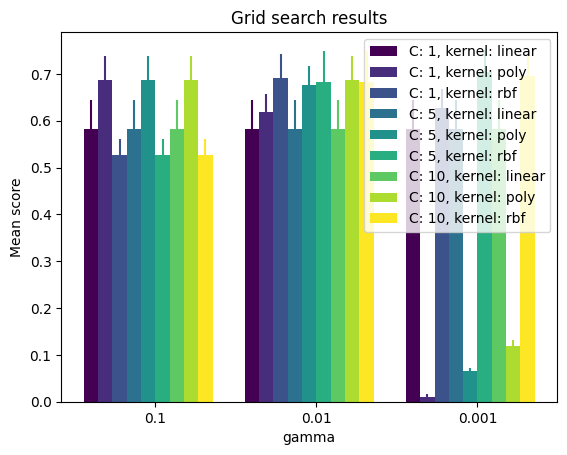

In [307]:
svrGridSearchResults = svrGridSearch.cv_results_
ax = plot.grid_search(svrGridSearch.cv_results_, change="gamma", kind='bar', sort=False)

In [308]:
from sklearn_evaluation import plot
bestSvr = SVR(C=1,gamma='auto',kernel='rbf', verbose=False)
bestSvr.fit(X_train,y_train)

SVR(C=1, gamma='auto')

<AxesSubplot: title={'center': 'Residuals Plot'}, xlabel='Predicted Value', ylabel='Residuals'>

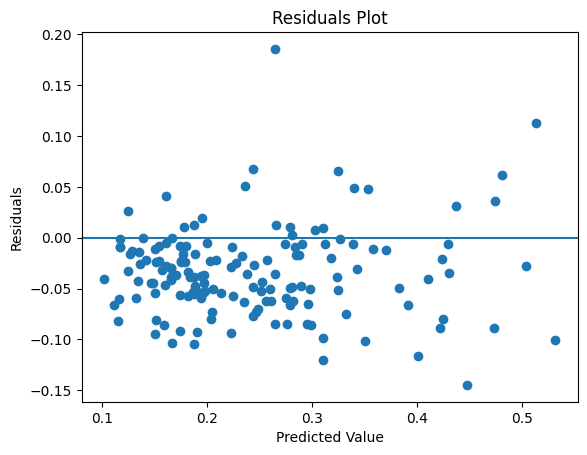

In [309]:
y_pred = bestSvr.predict(X_test)
y_true = y_test
plot.residuals(y_true, y_pred)

In [310]:
svr_test_results = cross_validate(bestSvr,X_test,y_test,scoring=["r2","neg_mean_squared_error"], verbose=False)
svr_test_results

{'fit_time': array([0.00300074, 0.00199986, 0.00300169, 0.00200009, 0.00300097]),
 'score_time': array([0.00300121, 0.00200057, 0.00199986, 0.00200057, 0.00200057]),
 'test_r2': array([0.31337523, 0.60990926, 0.36059615, 0.62322761, 0.55032831]),
 'test_neg_mean_squared_error': array([-0.00442881, -0.00530272, -0.0058156 , -0.00521931, -0.00615727])}

In [311]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4],
}
randomForestRegressor = RandomForestRegressor(random_state=0)

grid_search = GridSearchCV(estimator=randomForestRegressor,
                           param_grid=parameters,
                           scoring=["r2","neg_mean_squared_error"],
                           refit="r2",
                           cv=5, verbose=4)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END max_depth=1, n_estimators=100; neg_mean_squared_error: (test=-0.008) r2: (test=0.410) total time=   0.1s
[CV 2/5] END max_depth=1, n_estimators=100; neg_mean_squared_error: (test=-0.007) r2: (test=0.346) total time=   0.1s
[CV 3/5] END max_depth=1, n_estimators=100; neg_mean_squared_error: (test=-0.009) r2: (test=0.476) total time=   0.1s
[CV 4/5] END max_depth=1, n_estimators=100; neg_mean_squared_error: (test=-0.007) r2: (test=0.523) total time=   0.1s
[CV 5/5] END max_depth=1, n_estimators=100; neg_mean_squared_error: (test=-0.005) r2: (test=0.581) total time=   0.1s
[CV 1/5] END max_depth=1, n_estimators=150; neg_mean_squared_error: (test=-0.008) r2: (test=0.413) total time=   0.1s
[CV 2/5] END max_depth=1, n_estimators=150; neg_mean_squared_error: (test=-0.007) r2: (test=0.350) total time=   0.1s
[CV 3/5] END max_depth=1, n_estimators=150; neg_mean_squared_error: (test=-0.009) r2: (test=0.475) total time=  

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [100, 150, 200, 250, 300]},
             refit='r2', scoring=['r2', 'neg_mean_squared_error'], verbose=4)

In [312]:
print("BEST FOREST ESTIMATOR: " + str(grid_search.best_estimator_))
print("BEST SCORE: " + str(grid_search.best_score_))
print("BEST PARAMETERS" + str(grid_search.best_params_))

BEST FOREST ESTIMATOR: RandomForestRegressor(max_depth=4, n_estimators=150, random_state=0)
BEST SCORE: 0.8014582679461538
BEST PARAMETERS{'max_depth': 4, 'n_estimators': 150}


In [313]:
bestRandomForest = RandomForestRegressor(max_depth=4,n_estimators=150, random_state=0)
bestRandomForest.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=150, random_state=0)

<AxesSubplot: title={'center': 'Residuals Plot'}, xlabel='Predicted Value', ylabel='Residuals'>

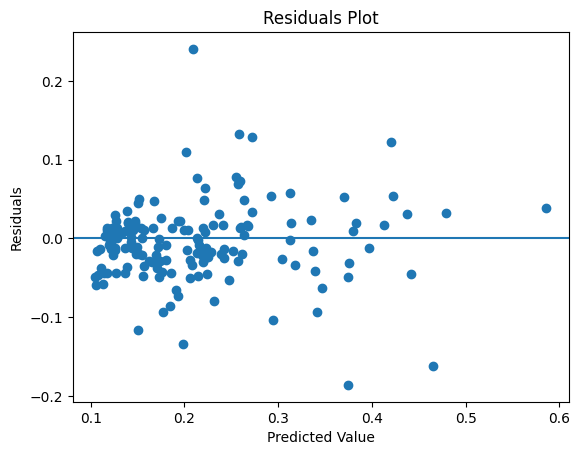

In [314]:
y_pred = bestRandomForest.predict(X_test)
y_true = y_test
plot.residuals(y_true, y_pred)

In [315]:
forest_test_results = cross_validate(bestRandomForest,X_test,y_test,scoring=["r2","neg_mean_squared_error"], verbose=False)
forest_test_results

{'fit_time': array([0.2090466 , 0.18404198, 0.22104979, 0.20704699, 0.18204212]),
 'score_time': array([0.00900221, 0.01000214, 0.01300287, 0.01000214, 0.0100019 ]),
 'test_r2': array([0.53672664, 0.71594412, 0.75003042, 0.81317565, 0.77858685]),
 'test_neg_mean_squared_error': array([-0.00298817, -0.00386133, -0.00227356, -0.00258802, -0.00303177])}

<AxesSubplot: >

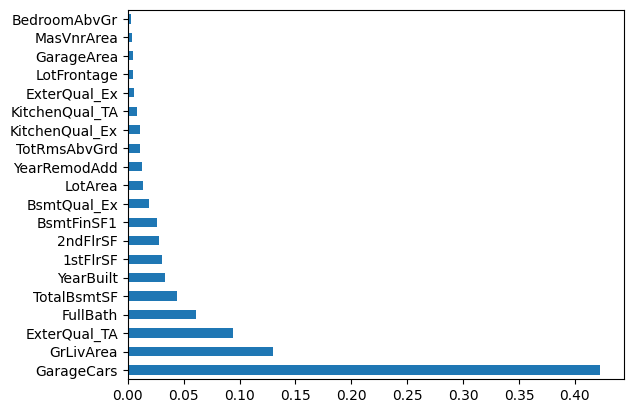

In [316]:
feat_importances = pd.Series(bestRandomForest.feature_importances_, index=X_train.columns).sort_values()
feat_importances.nlargest(20).plot(kind='barh')

In [317]:
fig = px.bar(feat_importances, orientation='h')
fig.write_html('importances.html')

In [318]:
X = X_test
y = y_test

# Condition the model on sepal width and length, predict the petal width
y_pred = bestSvr.predict(X)

fig = px.scatter(x=y, y=y_pred, labels={'x': 'ground truth', 'y': 'prediction'}, title="Prediction vs Expected SVR")
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y.min(), y0=y.min(),
    x1=y.max(), y1=y.max()
)
fig.show()

In [319]:
import plotly.express as px

df = scaled_test_data

# Condition the model on sepal width and length, predict the petal width
df['prediction'] = bestSvr.predict(X_test)
df['residual'] = df['prediction'] - scaled_test_data['SalePrice']

fig = px.scatter(
    df, x='prediction', y='residual',
    marginal_y='violin', trendline='ols', title="Residual SVR"
)
fig.show()

In [320]:
import plotly.express as px

df = scaled_test_data

# Condition the model on sepal width and length, predict the petal width
df['prediction'] = bestRandomForest.predict(X_test)
df['residual'] = df['prediction'] - scaled_test_data['SalePrice']

fig = px.scatter(
    df, x='prediction', y='residual',
    marginal_y='violin', trendline='ols', title="Residual RandomForrest"
)
fig.show()

In [321]:
import plotly.express as px

df = scaled_test_data

# Condition the model on sepal width and length, predict the petal width
df['prediction'] = best_tree_regressor.predict(X_test)
df['residual'] = df['prediction'] - scaled_test_data['SalePrice']

fig = px.scatter(
    df, x='prediction', y='residual',
    marginal_y='violin', trendline='ols', title="Residual Tree"
)
fig.show()

In [322]:
fig = px.scatter_3d(train_data, x='TotRmsAbvGrd', y='GrLivArea', z='YearBuilt',
                    color='SalePrice', symbol='GarageCars')
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0,
                                          ticks="outside"))
fig.update_layout(legend=dict(title_font_family="Times New Roman",
                              font=dict(size= 20)
))
fig.write_html('3d.html')

In [323]:
import umap
reducer = umap.UMAP(n_components=3, min_dist=0.1, n_neighbors=50).fit(scaled_train_data)
umap_train_data = reducer.transform(scaled_train_data)

In [324]:
umap_train_data

array([[14.993859,  8.916351,  9.191011],
       [10.296067,  9.492124, 10.430825],
       [10.748212,  9.185656, 10.52521 ],
       ...,
       [15.448926,  8.956013, 10.515993],
       [10.340727,  8.519091, 10.245589],
       [16.559778,  8.166257,  9.850017]], dtype=float32)

In [325]:
df_umap = pd.DataFrame(umap_train_data)
df_umap[['SalePrice','GarageCars']] = train_data[["SalePrice","GarageCars"]]
fig = px.scatter_3d(df_umap, x=0, y=1, z=2,
                    color='SalePrice', symbol='GarageCars')
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0,
                                          ticks="outside"))
fig.update_layout(legend=dict(title_font_family="Times New Roman",
                              font=dict(size= 20)
))
fig.write_html('3d_umap.html')

In [341]:
X = scaled_train_data
pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=scaled_train_data['SalePrice'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.write_html('3d_pca.html')

In [342]:
for i in range (0,255,5):
    if i == 1:
        continue
    pca = PCA(n_components=i, random_state=2020)
    components = pca.fit_transform(scaled_train_data)
    print("VARIANCE EXPLAINED BY ALL " + str(i) + " PRINCIPAL COMPONENTS = " + str(sum(pca.explained_variance_ratio_ *100)))

VARIANCE EXPLAINED BY ALL 0 PRINCIPAL COMPONENTS = 0
VARIANCE EXPLAINED BY ALL 5 PRINCIPAL COMPONENTS = 34.384747956835604
VARIANCE EXPLAINED BY ALL 10 PRINCIPAL COMPONENTS = 46.32963720931025
VARIANCE EXPLAINED BY ALL 15 PRINCIPAL COMPONENTS = 55.331131975214845
VARIANCE EXPLAINED BY ALL 20 PRINCIPAL COMPONENTS = 62.41681559894302
VARIANCE EXPLAINED BY ALL 25 PRINCIPAL COMPONENTS = 67.97345695734788
VARIANCE EXPLAINED BY ALL 30 PRINCIPAL COMPONENTS = 72.45682285664218
VARIANCE EXPLAINED BY ALL 35 PRINCIPAL COMPONENTS = 76.32465812855148
VARIANCE EXPLAINED BY ALL 40 PRINCIPAL COMPONENTS = 79.64185275780741
VARIANCE EXPLAINED BY ALL 45 PRINCIPAL COMPONENTS = 82.36185445966046
VARIANCE EXPLAINED BY ALL 50 PRINCIPAL COMPONENTS = 84.65531943415931
VARIANCE EXPLAINED BY ALL 55 PRINCIPAL COMPONENTS = 86.62185001055877
VARIANCE EXPLAINED BY ALL 60 PRINCIPAL COMPONENTS = 88.2991818701836
VARIANCE EXPLAINED BY ALL 65 PRINCIPAL COMPONENTS = 89.76298090073094
VARIANCE EXPLAINED BY ALL 70 PRINCIPA

In [134]:
most_corr_columns = sorted_highest_corr[:1000].reset_index()
most_corr =[]
reducted_train_data = scaled_train_data.copy()
for row in most_corr_columns['level_0']:
    if row in reducted_train_data.columns:
        reducted_train_data = reducted_train_data.drop(row, axis=1)
        most_corr.append(row)

updated_most_corr = reducted_train_data.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()
least_corr = scaled_train_data.drop(columns = most_corr)
most_corr = scaled_train_data.drop(columns = least_corr.columns)

print("POCET NAJVIAC KORELUJUCICH STLPCOV PRI 1000 HODNOTACH ", len(most_corr.columns))
print("POCET NAJMENEJ KORELUJUCICH STLPCOV PRI 1000 HODNOTACH ", len(least_corr.columns))
print(least_corr.shape)
print(most_corr.shape)


POCET NAJVIAC KORELUJUCICH STLPCOV PRI 1000 HODNOTACH  187
POCET NAJMENEJ KORELUJUCICH STLPCOV PRI 1000 HODNOTACH  69
(940, 69)
(940, 187)


In [157]:
#2
pca2 = PCA(n_components=2, random_state=2020)
components2 = pca2.fit_transform(most_corr)
print("VARIANCE EXPLAINED BY ALL " + str(2) + " PRINCIPAL COMPONENTS = " + str(sum(pca2.explained_variance_ratio_ *100)))

VARIANCE EXPLAINED BY ALL 2 PRINCIPAL COMPONENTS = 26.24318303178604


In [153]:
#3
pca3 = PCA(n_components=3, random_state=2020)
components3 = pca3.fit_transform(most_corr)
print("VARIANCE EXPLAINED BY ALL " + str(3) + " PRINCIPAL COMPONENTS = " + str(sum(pca3.explained_variance_ratio_ *100)))

VARIANCE EXPLAINED BY ALL 3 PRINCIPAL COMPONENTS = 30.515351738944155


In [137]:
#5
pca5 = PCA(n_components=5, random_state=2020)
components5 = pca5.fit_transform(most_corr)
print("VARIANCE EXPLAINED BY ALL " + str(5) + " PRINCIPAL COMPONENTS = " + str(sum(pca5.explained_variance_ratio_ *100)))

VARIANCE EXPLAINED BY ALL 5 PRINCIPAL COMPONENTS = 37.7982521665114


In [138]:
#10
pca10 = PCA(n_components=10, random_state=2020)
components10 = pca10.fit_transform(most_corr)
print("VARIANCE EXPLAINED BY ALL " + str(10) + " PRINCIPAL COMPONENTS = " + str(sum(pca10.explained_variance_ratio_ *100)))

VARIANCE EXPLAINED BY ALL 10 PRINCIPAL COMPONENTS = 50.640844299731995


In [139]:
#15
pca15 = PCA(n_components=15, random_state=2020)
components15 = pca15.fit_transform(most_corr)
print("VARIANCE EXPLAINED BY ALL " + str(15) + " PRINCIPAL COMPONENTS = " + str(sum(pca15.explained_variance_ratio_ *100)))

VARIANCE EXPLAINED BY ALL 15 PRINCIPAL COMPONENTS = 60.07460711298954


In [140]:
pca30 = PCA(n_components=30, random_state=2020)
components30 = pca30.fit_transform(most_corr)
print("VARIANCE EXPLAINED BY ALL " + str(30) + " PRINCIPAL COMPONENTS = " + str(sum(pca30.explained_variance_ratio_ *100)))

VARIANCE EXPLAINED BY ALL 30 PRINCIPAL COMPONENTS = 77.51158478034189


In [141]:
pca60 = PCA(n_components=60, random_state=2020)
components60 = pca60.fit_transform(most_corr)
print("VARIANCE EXPLAINED BY ALL " + str(60) + " PRINCIPAL COMPONENTS = " + str(sum(pca60.explained_variance_ratio_ *100)))

VARIANCE EXPLAINED BY ALL 60 PRINCIPAL COMPONENTS = 92.60254062048128


In [92]:
reductions = [components2,components3,components5,components15,components30,components60]

In [154]:
components2

array([[-1.46534494, -0.3903132 ],
       [ 1.59449142, -0.50943388],
       [ 0.75553443, -0.77028109],
       ...,
       [-0.67728427, -1.86428699],
       [ 2.21754734,  0.52575294],
       [-1.21412167,  0.00851172]])

In [155]:
def train_with_reduction(pca_parameter):
    reducted_train_data_pca = least_corr.copy()
    pca_reduction = pd.DataFrame(pca_parameter)
    ready_train = pd.concat([reducted_train_data_pca,pca_reduction], axis=1, join='inner')
    ready_train.columns = ready_train.columns.map(str)
    bestRandomForestPca = RandomForestRegressor(max_depth=4,n_estimators=150, random_state=2020)
    bestRandomForestPca.fit(ready_train, y_train)
    test_result_Best_random_forest_pca = cross_validate(bestRandomForestPca,X_test,y_test,scoring=["r2","neg_mean_squared_error"])
    print(test_result_Best_random_forest_pca)


In [158]:
train_with_reduction(components2)

{'fit_time': array([0.19304395, 0.50211334, 0.20804644, 0.20504665, 0.20004582]), 'score_time': array([0.01600337, 0.01900434, 0.01200294, 0.01300287, 0.00900102]), 'test_r2': array([0.58569746, 0.72383932, 0.77060491, 0.82817288, 0.79728255]), 'test_neg_mean_squared_error': array([-0.0026723 , -0.003754  , -0.00208643, -0.00238027, -0.00277577])}


In [ ]:
58569746, 0.72383932, 0.77060491, 0.82817288, 0.79728255